In [1]:

from pathlib import Path
import matplotlib.pyplot as plt
import lightning as L
import torch
import torch.nn as nn
from lit_llama import model
import random
from lit_llama import LLaMA, Tokenizer
from lit_llama.utils import EmptyInitOnDevice, lazy_load, llama_model_lookup

/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
fabric = L.Fabric(devices=1)
tokenizer_path: Path = Path("checkpoints/lit-llama/tokenizer.model")
tokenizer = Tokenizer(tokenizer_path)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [186]:
import json
with open('datasets/alpaca_data_cleaned.json') as f:
    alpaca_json = json.load(f)

# Create tokenized j
alpaca_json_tokens = []

for item in alpaca_json:
    alpaca_json_tokens.append(
        {
            'instruction': tokenizer.encode(item['instruction'], bos=False, eos=False, device=fabric.device),
            'input': tokenizer.encode(item['input'], bos=False, eos=False, device=fabric.device),
            'output':tokenizer.encode(item['output'], bos=False, eos=False, device=fabric.device)
        }
    )

In [3]:
def get_batch(batch_size=10):
    batch_indices = random.sample(range(len(alpaca_json_tokens)), k=batch_size)
    
    
    # IST tokens
    IST_tokens = []
    for index in batch_indices:
        llama_input = torch.cat([alpaca_json_tokens[index]['instruction'], alpaca_json_tokens[index]['input']]).unsqueeze(0)
        IST_tokens.append(IST_generator(LLamaModel(llama_input)[1])[:,-1,:])

    # get shortest
    shortest_output_len = 1000
    for item in batch_indices:
        if(len(alpaca_json_tokens[item]['output']) < shortest_output_len):
            shortest_output_len = len(alpaca_json_tokens[item]['output'])


    length = random.randint(0,shortest_output_len-1)
    inputs = []
    targets = []

    for item in batch_indices:
        inputs.append(alpaca_json_tokens[item]['output'][:length])
        targets.append(alpaca_json_tokens[item]['output'][:length+1])
    
    return torch.stack(inputs), torch.stack(targets), torch.stack(IST_tokens)


In [4]:
checkpoint_path: Path = Path("checkpoints/lit-llama/7B/lit-llama.pth")
tokenizer_path: Path = Path("checkpoints/lit-llama/tokenizer.model")


def load_LLaMA(checkpoint_path):
    with lazy_load(checkpoint_path) as checkpoint:
        name = llama_model_lookup(checkpoint)

        with EmptyInitOnDevice(
                device=fabric.device, dtype=dtype, quantization_mode=None # We won't quantize the weights
        ):
            model = LLaMA.from_name(name)

        model.load_state_dict(checkpoint)
    return model

In [6]:

dtype = torch.bfloat16 if fabric.device.type == "cuda" and torch.cuda.is_bf16_supported() else torch.float32

LLaMA_config = model.LLaMAConfig.from_name('7B')
print('Loading models...')
# Load the LLaMa model and the IST generator (also a LLaMA model)
LLamaModel = load_LLaMA(checkpoint_path).to(fabric.device)
#LLamaModel = LLaMA(LLaMA_config)
print('Finished loading the first model')
print('Finished loading models')
tokenizer = Tokenizer(tokenizer_path)

IST_schemes = ['vanilla', 'last 4', '2nd to last', 'all layers']
scheme_losses = {}

IST_generator = model.Block(LLaMA_config)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(IST_generator.parameters(), lr=1e-4)
IST_generator = IST_generator.to(fabric.device)

Loading models...
Finished loading the first model
Finished loading models


In [ ]:
class prefix_tuner(nn.Module):
    

In [139]:
IST_generator.load_state_dict(torch.load('weights.pt'))


<All keys matched successfully>

In [143]:
IST_generator = IST_generator.to(fabric.device)

In [7]:
for param in LLamaModel.parameters():
    param.requires_grad=False

In [140]:
losses = []

In [160]:
optimizer = torch.optim.Adam(IST_generator.parameters(), lr=1e-4)

In [203]:
# Training loop
LLamaModel.train()
for epoch in range(1000):
    inputs, targets, IST_tokens = get_batch(64)
    
    inputs = inputs.to(fabric.device)
    targets = targets.to(fabric.device)
    IST_tokens = IST_tokens.to(fabric.device)
    #print(tokenizer.decode(inputs))
    #print(tokenizer.decode(targets))
    predicted_logits = LLamaModel(inputs, IST_tokens.type(torch.bfloat16))[0]
    #print('decoded: ', tokenizer.decode(torch.argmax(predicted_logits, dim=2)))
    loss = loss_fn(predicted_logits.permute(0,2,1).to(fabric.device), targets.type(torch.LongTensor).to(fabric.device))

    optimizer.zero_grad()
    loss.backward()
    print(f'epoch{epoch}, loss: {loss.item()}')
    losses.append(loss.item())
    optimizer.step()

epoch0, loss: 0.73828125
epoch1, loss: 1.5078125
epoch2, loss: 1.2109375
epoch3, loss: 1.1953125
epoch4, loss: 1.7265625
epoch5, loss: 1.578125
epoch6, loss: 1.3828125
epoch7, loss: 1.3828125
epoch8, loss: 0.890625
epoch9, loss: 1.375
epoch10, loss: 1.296875
epoch11, loss: 1.6484375
epoch12, loss: 1.1484375
epoch13, loss: 1.6484375
epoch14, loss: 1.515625
epoch15, loss: 1.03125
epoch16, loss: 1.84375
epoch17, loss: 1.2578125
epoch18, loss: 1.4609375
epoch19, loss: 1.6640625
epoch20, loss: 1.546875
epoch21, loss: 1.171875
epoch22, loss: 1.265625
epoch23, loss: 1.59375
epoch24, loss: 1.3046875
epoch25, loss: 1.3515625
epoch26, loss: 1.03125
epoch27, loss: 1.1796875
epoch28, loss: 1.703125
epoch29, loss: 1.1953125
epoch30, loss: 1.0703125
epoch31, loss: 1.5
epoch32, loss: 1.7109375
epoch33, loss: 1.4765625
epoch34, loss: 1.2421875
epoch35, loss: 1.609375
epoch36, loss: 1.484375
epoch37, loss: 1.0703125
epoch38, loss: 1.5078125
epoch39, loss: 1.4453125
epoch40, loss: 1.71875
epoch41, loss:

KeyboardInterrupt: 

Text(0, 0.5, 'loss')

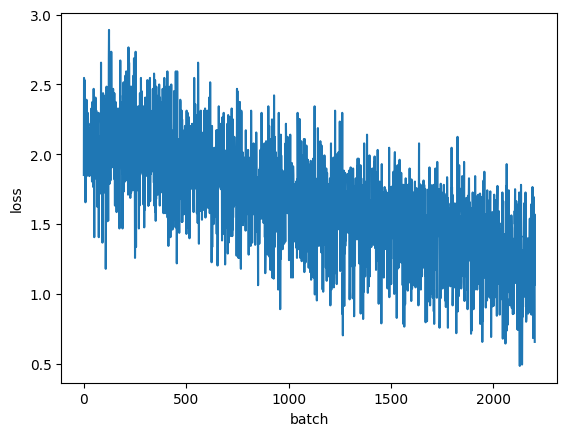

In [204]:
plt.plot(losses)
plt.xlabel('batch')
plt.ylabel('loss')

In [12]:
def get_IST(string):
    tokens = tokenizer.encode(string).unsqueeze(0).type(torch.LongTensor).to(fabric.device)
    x = LLamaModel(tokens)[1]
    x = IST_generator(x)
    return x[:,-1,:]

In [150]:
def generate(model, tokenizer, prompt, IST=None, max_new_tokens=200):
  
    
    generated = ''
    tokenized_input = tokenizer.encode(prompt).to(fabric.device)
    with torch.no_grad():

        for _ in range(max_new_tokens):
            last_logits = model(tokenized_input.unsqueeze(0), IST.type(torch.bfloat16))[0][:,-1,:]
            new_token = torch.argmax(last_logits, dim=1)
            generated += tokenizer.decode(new_token)
            tokenized_input = torch.cat([tokenized_input, new_token])
    
    print(tokenizer.decode(tokenized_input))
    return tokenized_input

In [208]:
generated = generate(LLamaModel, tokenizer, prompt='', IST=get_IST('What is the average temperature in China?'))

The average temperature in the United States is 57 degrees Fahrenheit.
The average temperature in the United States is 57 degrees Fahrenheit. The average temperature in the United States is 57 degrees Fahrenheit. The average temperature in the United States is 57 degrees Fahrenheit. The average temperature in the United States is 57 degrees Fahrenheit. The average temperature in the United States is 57 degrees Fahrenheit. The average temperature in the United States is 57 degrees Fahrenheit. The average temperature in the United States is 57 degrees Fahrenheit. The average temperature in the United States is 57 degrees Fahrenheit. The average temperature in the United States is 57 degrees Fahrenheit. The average temperature in the United States is 57 degrees Fahrenheit. The average temperature in the United States is 57 degrees Fahrenheit. The average temperature in the United States


In [205]:
torch.save(IST_generator.state_dict(), 'weights.pt')